Start with autoreload magic; this reloads modules automatically before entering the execution of code and thus enabled development in modules like util.py

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import os
from glob import glob

import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt

import config

import util

In [15]:
obspack_dir = "/glade/work/mclong/sno-analysis/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc"
obspack_filenames = [ # now including aircraft
    f"{obspack_dir}/co2_alt_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_brw_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_cba_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_cgo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_kum_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_ljo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_mlo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_psa_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_smo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_spo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_hip_aircraft-insitu_59_allvalid.nc",
    f"{obspack_dir}/co2_orc_aircraft-insitu_3_allvalid-merge10.nc",
    f"{obspack_dir}/co2_tom_aircraft-insitu_1_allvalid.nc",
    f"{obspack_dir}/co2_gould_shipboard-insitu_1_allvalid.nc",
    f"{obspack_dir}/co2_aoa_aircraft-flask_19_allvalid.nc",
]

obspack_files = {}
station_list = []
for f in obspack_filenames:
    stn = os.path.basename(f).split('_')[1]
    station_list.append(stn)
    obspack_files[stn] = os.path.basename(f)

### Contribution details
- 15 Obspack netcdf files (e.g. nicam-tm_gl5_mlo_surface-flask_4_representative.nc) each with all 10 tracers
    - no 'time', just 'time_components' and 'time_decimal'
- including 3 ship files in ObsPack format
- including full ObsPack (one netcdf file per year)
- including 3-hourly output at fixed sites

In [16]:
sno_vars = [
    'apo_jena',
    'o2_cesm', 
    'o2_gk01r16',  
    'o2_gridfed',   
    'co2_cesm', 
    'co2_somffn', 
    'co2_gridfed', 
    'co2_oco2mip', 
    'n2_cesm', 
    'n2_era', 
] # without derived vars

X_O2 = 0.2094 

droot = "/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/NICAM-TM_gl6/required_obspack"

station_records = {}
for station in station_list:

    path = f"{droot}/{obspack_files[station].replace('co2_','nicam-tm_gl6_')}"
    
    print(path)
    ds = xr.open_dataset(path)

    # no variable 'time' - recreate from time_components
    tc = ds['time_components']
    tc = tc.to_dataframe(dim_order=['calendar_components','obs']).unstack(level=0)
    tc.columns = ['year', 'month', 'day', 'hour', 'minute', 'second'] 
    ds['time'] = pd.to_datetime(tc)

    # get time as coordinate
    time = ds.time
    time.name = 'obs'
    ds['obs'] = time
    ds = ds.drop('time').rename({'obs': 'time'})

    # get rid of missing value codes
    _FillValue = -999999
    for v in sno_vars:
        ds[v] = ds[v].where(ds[v] != _FillValue)

    # convert apo_jena to per meg
    ds['apo_jena'] = ds['apo_jena']/X_O2
   
    # add derived APO variables

    ds['apo_cesm'] = util.compute_apo (
        o2=ds['o2_cesm'],
        co2=ds['co2_cesm'],
        n2=ds['n2_cesm']
    )

    ds['apo_diss'] = util.compute_apo (
        o2=ds['o2_gk01r16'],
        co2=ds['co2_somffn'],
        n2=ds['n2_era']
    )

    ds['apo_gridfed'] = util.compute_apo (
        o2=ds['o2_gridfed'],
        co2=ds['co2_gridfed'],
        n2=0.0
    )

    ds['apo_oco2mip'] = util.compute_apo (
        o2=ds['co2_oco2mip'] * -1.4,
        co2=ds['co2_oco2mip'],
        n2=0.0
    )

    ds.to_netcdf(f"inverse_model_obspack_files/NICAM-TM_gl6/{obspack_files[station]}")
    
    station_records[station] = ds

/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/NICAM-TM_gl6/required_obspack/nicam-tm_gl6_alt_surface-flask_4_representative.nc
/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/NICAM-TM_gl6/required_obspack/nicam-tm_gl6_brw_surface-flask_4_representative.nc
/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/NICAM-TM_gl6/required_obspack/nicam-tm_gl6_cba_surface-flask_4_representative.nc
/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/NICAM-TM_gl6/required_obspack/nicam-tm_gl6_cgo_surface-flask_4_representative.nc
/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/NICAM-TM_gl6/required_obspack/nicam-tm_gl6_kum_surface-flask_4_representative.nc
/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/NICAM-TM_gl6/required_obspack/nicam-tm_gl6_ljo_surface-flask_4_representative.nc
/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/NICAM-TM_gl6/required_obspack/nicam-tm_gl6_mlo_surface-flask_4_representative.nc

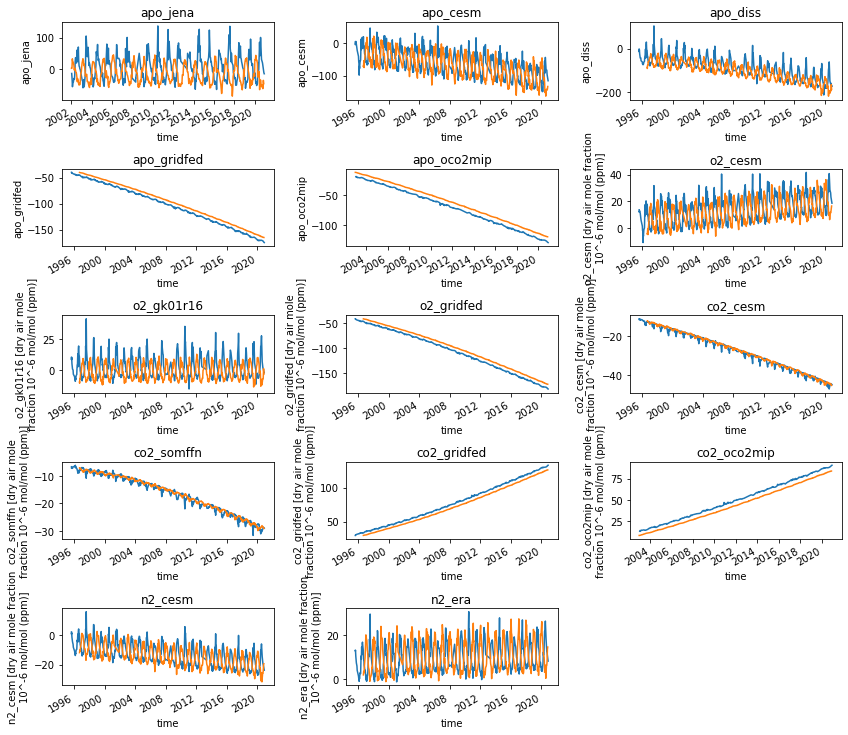

In [17]:
# plot timeseries 

sno_vars = [
    'apo_jena',
    'apo_cesm',
    'apo_diss',
    'apo_gridfed',
    'apo_oco2mip',
    'o2_cesm', 
    'o2_gk01r16',  
    'o2_gridfed',   
    'co2_cesm', 
    'co2_somffn', 
    'co2_gridfed', 
    'co2_oco2mip', 
    'n2_cesm', 
    'n2_era', 
] # including derived vars

station_plot_list=['cba','psa']

n_plots = len(sno_vars)
ncol = int(np.sqrt(n_plots))
nrow = int(((n_plots / ncol) + n_plots % ncol))
fig, axs = plt.subplots(nrow, ncol, figsize=(12, 12), squeeze=False)

for n, v in enumerate(sno_vars):
    ip, jp = np.unravel_index(n, axs.shape)
    
    ax = axs[ip, jp]
    for stn in station_plot_list:
        station_records[stn][v].plot(ax=ax)
    ax.set_title(v)

plt.tight_layout();    

for n in range(n+1, nrow*ncol):
    ip, jp = np.unravel_index(n, (nrow, ncol))
    axs[ip, jp].remove()
    

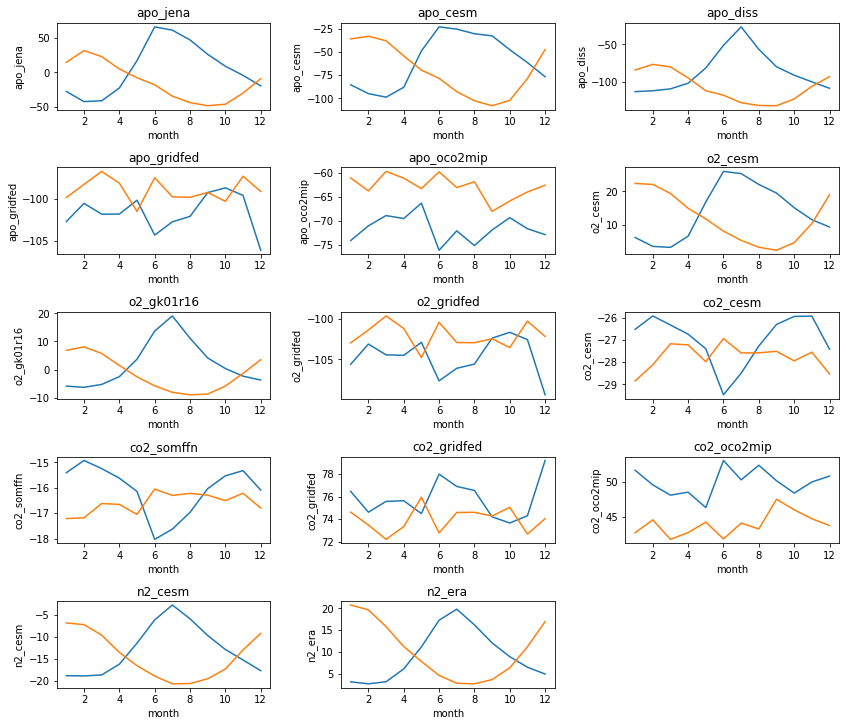

In [18]:
# seasonal climatology

fig, axs = plt.subplots(nrow, ncol, figsize=(12, 12), squeeze=False)

for n, v in enumerate(sno_vars):
    ip, jp = np.unravel_index(n, axs.shape)
    
    ax = axs[ip, jp]
    for stn in station_plot_list:
        ds_seas=station_records[stn][v].groupby('time.month').mean('time')
        ds_seas.plot(ax=ax)
    ax.set_title(v)

plt.tight_layout();    

for n in range(n+1, nrow*ncol):
    ip, jp = np.unravel_index(n, (nrow, ncol))
    axs[ip, jp].remove()
    